# Trim Analysis

This section outlines a basic analysis for triming the airplane at given conditions, and hence, determine if the elevator is sized appropriately. At a given condition (such as takeoff), the analysis involves computing the pitching moment coefficient $C_M$ of the airplane about CG. Then, determine what tail incidence/elevator deflection can yield zero $C_M$. Note that changing the tail lift will change the total airplane lift which should be equal to weight (for a steady flight). Hence, free-stream angle of attack needs to be changed. This leads to an iterative process where angle of attack and elevator deflection are to be determined such that $C_{M_{cg}} = 0$ and lift is equal to weight. This can be done using a computer or a graphical analysis.

> __*NOTE*__: Trim analysis is usually performed at takeoff and landing conditions to size/validate the horizontal tail and elevator's effectiveness in trimming the airplane. The most forward CG position is used for performing landing/takeoff trim analysis.

In this section, only **landing trim analysis** is demonstrated for the example airplane. The total lift coefficient of the airplane is written as:

$$
    C_{L_{total}} = C_{L_w} + C_{L_h},
$$

where $C_{L_w}$ and $C_{L_h}$ are the lift coefficient for wing and horizontal tail, respectively. Using equation 16.7 in Raymer, the pitching moment coefficient about CG can be computed using

$$
    C_{M_{cg}} = C_{L_w}(\bar{X}_{cg} - \bar{X}_{ac_w}) + C_{M_w} + C_{M_{w_f}} + C_{M_{fus}} - \eta_h \frac{S_h}{S_w} C_{L_h} (\bar{X}_{ac_h} - \bar{X}_{cg}),
$$

where $C_{M_w}$ refers to the wing pitching moment and $C_{M_{w_f}}$ refers to the change in the wing pitching moment coefficient due to wing flap deflection. Other terms have been defined in [static margin section](static_margin.ipynb).

> __*NOTE*__: The thrust effect can be ignored for initial analysis, unless the vertical distance between thrust line and CG is large.

Using above equation, one can find the $\alpha$ and elevator deflection so that $C_{M_{cg}} = 0$ while maintaining a specific $C_L$. Following sub-sections compute the pitching moment contributions from different components:

## Wing

### Lift model

The lift model for the wing can be written as

$$
    C_{L_w} = C_{L_{\alpha_w}} (\alpha + i_w - \alpha_{0_{L_w}}),
$$

where $C_{L_{\alpha_w}}$ is the lift curve slope for the wing, $i_w$ is the incidence angle, $\alpha_{0_{L_w}}$ is the zero-lift angle of attack for the wing. The $C_{L_{\alpha_w}}$ and $\alpha_{0_{L_w}}$ are already computed in [aerodynamics section](../aerodynamics/lift_curve.ipynb) and [high-lift devices section](../hl_devices/landing.ipynb). The $i_w = 2^{\circ}$ is determined in [wing planform section](../wing_layout.ipynb). Note that $i_w$ can be changed if required. Below block creates a python function for computing $C_{L_w}$:

In [26]:
import numpy as np

def compute_CL_w(alpha, i_w=2):
    """
        Note: this function will compute CL with landing flaps

        Input should be in degrees
    """

    CL_alpha_w = 5.0 # 1/rad
    alpha_CLzero_w = -8.8 # deg, computed in HL devices for landing
    CL = CL_alpha_w * (alpha + i_w - alpha_CLzero_w) * np.pi / 180

    return CL

### Pitching moment

The wing pitching moment coefficient about the aerodynamic center is comptued using (Raymer, equation 16.19)

$$
    C_{W_m} = C_{m_{0_{airfoil}}} \bigg( \frac{A}{A + 2} \bigg),
$$

where $C_{m_{0_{airfoil}}}$ is the airfoil pitching moment coefficient about aerodynamic center and $A$ is the wing aspect ratio. Note that the above equation can be further modified to account for wing wing sweep. To account for the wing twist, the $C_{W_m}$ is incremented by $-0.01 \times twist$. The airfoil pitching moment coefficient can be computed using software such as XFOIL. For the airfoil used in the wing of the example airplane, $C_{m_{0_{airfoil}}}$ is found to be -0.009. Below code block computes $C_{M_w}$:

In [27]:
Aw = 8
twist = -3 # deg
Cm0_airfoil = -0.01
CM_w = Cm0_airfoil * Aw / (Aw+2)
CM_w += -0.01*twist

print(f"Wing pitching moment about CG: {CM_w:.4f}")

Wing pitching moment about CG: 0.0220


The change in wing pitching moment coefficient with respect to wing flap deflection $\delta_f$ is computed

$$
    C_{M_{w_f}} = - \Delta C_L (\bar{X}_{cp} - \bar{X}_{cg}),
$$

where $\bar{X}_{cp}$ is the center of pressure of the flap lift increment and $\Delta C_L$ is the change in lift coefficient due to wing flap deployment. Note that $\Delta C_L = 0.76$ for landing flaps, as determined in HL devices section. The $\bar{X}_{cp}$ is determined using Figure 16.9 in Raymer. Below code block computes $C_{M_{w_f}}$:

In [28]:
delta_CL = 0.76
Xcp = 0.44
Xcg = 0.1 # most forward CG
CM_w_flap = -delta_CL * (Xcp - Xcg)

print(f"Change in wing pitching moment due to flaps: {CM_w_flap:.4f}")

Change in wing pitching moment due to flaps: -0.2584


## Tail

The tail lift model is written as

$$
    C_{L_h} = C_{L_{\alpha_h}} \alpha_h,
$$

where $C_{L_{\alpha_h}}$ is the lift curve slope for the horizontal tail (computed in static margin section) and $\alpha_h$ is the angle of attack experienced by the horizontal tail. The $\alpha_h$ is influenced by the downwash from the wing and can be written as

$$
    \alpha_h = (\alpha + i_w) \bigg(1 - \frac{\partial \epsilon}{\partial \alpha}\bigg) + (i_h - i_w) + \alpha_{h_{L=0}} - \Delta \epsilon_{\delta},
$$

where $i_h$ is the horizontal tail incidence angle, $\partial \epsilon / \partial \alpha$ is the change in downwash with respect to change in angle of attack (computed in statis margin section). The $\alpha_{h_{L=0}}$ is the zero-lift angle of attack for the horizontal tail which depends on the elevator deflection $\delta_e$. The $\Delta \epsilon_{\delta}$ represents change in downwash due to the wing flap deployment. Hence, $C_{L_h}$ depends on angle of attack and elevator deflection.

The $\alpha_{h_{L=0}}$ is zero since symmetrical airfoil is used for horizontal tail. However, it changes when there is elevator deflection. Hence, $\alpha_{h_{L=0}}$ is estimated as (Raymer, equation 16.16 and 16.18)

$$
    \alpha_{h_{L=0}} = -\big[ 1.576 (c_e/c)^3 - 3.458 (c_e/c)^2 + 2.882 (c_e/c) \big] \delta_e, 
$$

where $c_e/c$ is the elevator chord ratio and is choosen as 0.4. Note that elevator down is considered as positive.

The $\Delta \epsilon_{\delta}$ is estimated using Figure 16.13 in Raymer. Note that $C_{L_{\alpha_h}}$ does not change with elevator deflection. Below code block defines a function for computing tail lift coefficient:

In [29]:
def compute_CL_ht(alpha, elevator, i_w=2, i_h=0):
    """
        Note: this function will compute CL_ht with landing flaps

        All inputs should be in degrees.
    """

    de_da = 0.3812 # computed in static margin section
    ce_c = 0.4
    delta_epsilon = 4.275 # deg 
    CLalpha_ht = 4.4747 # 1/rad

    zero_lift_alpha_ht = -(1.576*ce_c**3 - 3.458*ce_c**2 + 2.882*ce_c)*elevator # deg

    alpha_ht = (alpha + i_w)*(1 - de_da) + (i_h - i_w) - zero_lift_alpha_ht - delta_epsilon

    CL_ht = CLalpha_ht * alpha_ht * np.pi / 180

    return CL_ht

> __*NOTE*__: The pitching moment of tail about its aerodynamic center are usually small, and hence, can be neglected

## Fuselage

The fuselage pitching moment can computed using a simple model, given by

$$
    C_{M_{fus}} = C_{M_{\alpha_{fus}}} \alpha,
$$

where $C_{M_{\alpha_{fus}}}$ is computed in static margin section. Below code block defines a function for computing $C_{M_{fus}}$:

In [30]:
def compute_CM_fus(alpha):
    """
        Alpha should be in degrees.
    """

    CM_alpha_fus = 1.1783 # 1/rad

    return CM_alpha_fus * alpha * np.pi / 180

## Landing trim

Now, the trim analysis can be performed in landing configuration. In this demonstration, graphical method is used for triming. It consists of plotting $C_{M_{cg}}$ vs $C_{L_{total}}$ for a range of $\alpha$ at different elevator deflections. Then, visually estimating a point where $C_{M_{cg}}=0$ and $C_{L_{total}}$ is equal to desired value.

> __*NOTE*__: The ground effect and pitching moment from landing gear is ignored in this analysis.

Below code block plots the trim crossplot:

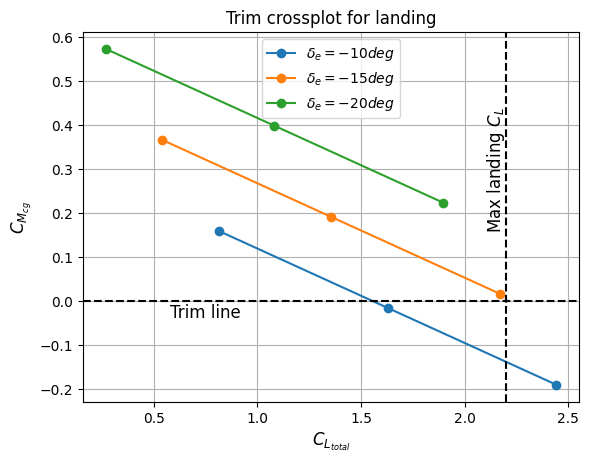

In [42]:
import matplotlib.pyplot as plt

# Parameters
i_w = 2
mac = 4.3 # ft
Xac_w = 0.25 # quarter chord
tail_moment_arm = 15 # ft
Xac_h = Xac_w + tail_moment_arm/mac # distance from LE MAC
nh = 0.9
Sw = 134 # sq ft
Sh = 31 # sq ft.
fs = 12

# Plotting parameters
elevator_deflections = [-10, -15, -20] # deg
alpha = np.linspace(6,18,3) # deg

# Plot
fig, ax = plt.subplots()

for deflection in elevator_deflections:

    # Lift
    CL_w = compute_CL_w(alpha, i_w)
    CL_ht = compute_CL_ht(alpha, deflection, i_w)
    CL_total = CL_w + CL_ht

    # Pitching moment
    CM_cg = CL_w * (Xcg - Xac_w) + CM_w + CM_w_flap + compute_CM_fus(alpha) - nh * Sh / Sw * CL_ht * (Xac_h - Xcg)

    ax.plot(CL_total, CM_cg, label=f"$\delta_e = {deflection} deg$", marker="o")

ax.axhline(y=0, color="k", linestyle="--")
ax.axvline(x=2.2, color="k", linestyle="--")
ax.annotate("Trim line", (0.75, -0.025), ha="center", va="center", fontsize=fs)
ax.annotate("Max landing $C_L$", (2.15,0.3), rotation=90, ha="center", va="center", fontsize=fs)
ax.set_xlabel("$C_{L_{total}}$", fontsize=fs)
ax.set_ylabel("$C_{M_{cg}}$", fontsize=fs)
ax.set_title("Trim crossplot for landing", fontsize=fs)
ax.grid()
ax.legend(loc="upper center")

Based on the above plot, it can be said that example airplane can be trimmed using $-15^{\circ}$ elevator deflection while attaining maximum landing lift coefficient. If the airplane cannot be trimmed, then one should vary some of the parameters such as tail airfoil, tail-moment arm (this might slightly change CG calculations), $c_e/c$, etc. The usual maximum elevator deflection is around $\pm30^{\circ}$, so one should avoid higher trim elevator deflections.

This concludes the trim analysis at landing condition. Futhermore, one can also plot the trimmed drag polar at landing condition using equation 16.34 in Raymer for computing trimmed induced drag. A similar analysis should be performed at different flight conditions such as takeoff and cruise to verfiy whether elevator can trim the airplane or not.